In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load Data

In [3]:
df =  pd.read_csv('data/training_v2.csv')
print(f'rows: {df.shape[0]}, columns: {df.shape[1]}')

rows: 91713, columns: 186


In [4]:
df.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [5]:
df.shape

(91713, 186)

In [6]:
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
data_dict

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None
...,...,...,...,...,...,...
183,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
184,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1
185,APACHE grouping,apache_3j_bodysystem,None,string,Admission diagnosis group for APACHE III,Cardiovascular
186,APACHE grouping,apache_2_bodysystem,None,string,Admission diagnosis group for APACHE II,Respiratory


In [7]:
data_dict['Category'].value_counts()

labs                         60
vitals                       52
APACHE covariate             28
labs blood gas               16
demographic                  16
APACHE comorbidity            8
identifier                    3
APACHE grouping               2
APACHE prediction             2
GOSSIS example prediction     1
Name: Category, dtype: int64

In [8]:
data_dict['Data Type'].value_counts()

numeric    153
binary      16
string      12
integer      7
Name: Data Type, dtype: int64

# Drop non_useful features

In [9]:
identifier_features =data_dict[data_dict['Category']=='identifier']['Variable Name'].tolist() + ['icu_id']
identifier_features

['encounter_id', 'hospital_id', 'patient_id', 'icu_id']

In [10]:
type__features=['hospital_admit_source','icu_admit_source', 'icu_stay_type','icu_type']

In [11]:
redundant_features = ['readmission_status', 'apache_2_bodysystem']

In [12]:
features_to_drop = identifier_features + type__features +redundant_features
features_to_drop

['encounter_id',
 'hospital_id',
 'patient_id',
 'icu_id',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'readmission_status',
 'apache_2_bodysystem']

In [13]:
df = df.drop(columns=features_to_drop)
df.head(1)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,pre_icu_los_days,weight,albumin_apache,...,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
0,0,68.0,22.73,0,Caucasian,M,180.3,0.541667,73.9,2.3,...,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis


# Handling Missing values

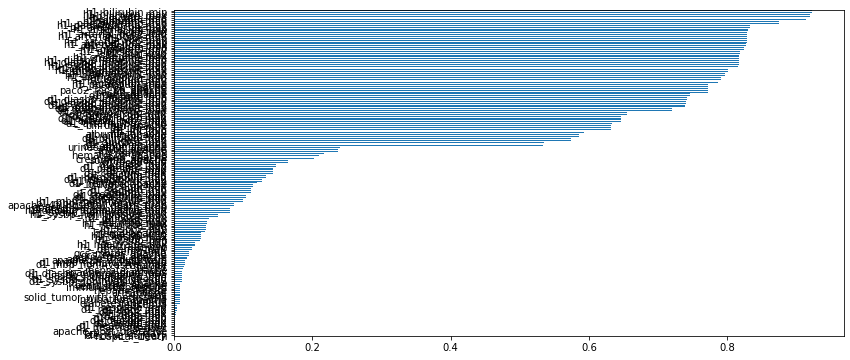

In [14]:
# Percentage of null values 
(df.isnull().sum().sort_values()/df.shape[0]).plot.barh(figsize =(12,6))

## Dropping missing values

In [15]:
# keep features that have less than 70% of nulls
cut_off_percentage = .3
n_of_nulls = int(cut_off_percentage * df.shape[0])

In [16]:
df = df.dropna(axis=1, thresh = n_of_nulls)
df.shape

(91713, 121)

## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [17]:
#get numeric feature names 
# ['bmi','apache_2_diagnosis','apache_3j_diagnosis'] are suppose be numeric features, so add them back
numeric_features = data_dict[data_dict['Data Type']=='numeric']['Variable Name'].tolist()+ ['bmi','apache_2_diagnosis','apache_3j_diagnosis']
len(numeric_features)

156

In [18]:
# get numeric features in the skewed dataset
skewed_numeric_features = df.columns[df.columns.isin(numeric_features)]
len(skewed_numeric_features)

100

In [19]:
numeric_df = df[skewed_numeric_features]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,68.0,22.73,180.3,0.541667,73.9,2.3,113.0,502.01,0.4,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05
1,77.0,27.42,160.0,0.927778,70.2,NaN,108.0,203.01,NaN,9.0,...,1.3,1.3,37.0,37.0,7.45,7.45,51.0,51.0,0.47,0.29
2,25.0,31.95,172.7,0.000694,95.3,NaN,122.0,703.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00


In [20]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [22]:
imp = IterativeImputer(max_iter=1, verbose=0)
imp.fit(numeric_df)
imputed_df = imp.transform(numeric_df)
imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [23]:
imputed_df.isnull().sum().sum()

0

### Categorical variables

In [24]:
categorical_features = data_dict[data_dict['Data Type']!='numeric']['Variable Name'].tolist()

In [25]:
#remove ['bmi','apache_2_diagnosis','apache_3j_diagnosis'] non_categorical features
categorical_features =[feature for feature in categorical_features if feature not in ['bmi','apache_2_diagnosis','apache_3j_diagnosis']]

In [26]:
skewed_categorical_features = df.columns[df.columns.isin(categorical_features)]
len(skewed_categorical_features)

21

In [27]:
categorical_df = df[skewed_categorical_features]
categorical_df.head(3)

,hospital_death,elective_surgery,ethnicity,gender,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,...,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
0,0,0,Caucasian,M,0,0.0,3.0,6.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis
1,0,0,Caucasian,F,0,0.0,1.0,3.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory
2,0,0,Caucasian,F,0,0.0,3.0,6.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic


In [28]:
# fill the null with the most occurred values
# df.series.mode() returns a series. so [0] exact value of the series
for feature in skewed_categorical_features:
    categorical_df[feature].fillna(categorical_df[feature].mode()[0],inplace=True)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [29]:
numeric_df.shape, categorical_df.shape

((91713, 100), (91713, 21))

In [30]:
# concat two data frame together horizontally
complet_df = pd.concat([imputed_df, categorical_df], axis = 1)
complet_df

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
0,68.000000,22.730000,180.3,0.541667,73.900000,2.300000,113.0,502.01,0.400000,31.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis
1,77.000000,27.420000,160.0,0.927778,70.200000,1.566189,108.0,203.01,0.311166,9.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory
2,25.000000,31.950000,172.7,0.000694,95.300000,2.924985,122.0,703.03,1.133633,25.765689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic
3,81.000000,22.640000,165.1,0.000694,61.700000,2.839223,203.0,1206.03,1.132054,26.201220,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular
4,19.000000,22.735624,188.0,0.073611,85.146752,2.932082,119.0,601.01,1.134308,25.679708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.000000,23.060250,177.8,0.298611,72.900000,2.805806,113.0,501.06,1.183286,30.345618,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis
91709,56.000000,47.179671,183.0,0.120139,158.000000,2.920253,113.0,501.05,1.112282,34.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis
91710,48.000000,27.236914,170.2,0.046528,78.900000,2.900000,123.0,702.01,1.145228,33.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic
91711,71.011615,23.297481,154.9,0.081944,55.900000,2.925753,108.0,203.01,1.105058,25.748169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory


In [31]:
complet_df.isnull().sum().sum()

0

# Feature creation

The Glasgow Coma Scale (GCS) is the most common scoring system used to describe the level of consciousness in a person following a traumatic brain injury.
Clinicians use this scale to rate the best eye opening response, the best verbal response, and the best motor response an individual makes. The final GCS score or grade is the sum of these numbers.

In [32]:
complet_df.loc[:,['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']]

,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache
0,3.0,6.0,4.0
1,1.0,3.0,1.0
2,3.0,6.0,5.0
3,4.0,6.0,5.0
4,4.0,6.0,5.0
...,...,...,...
91708,4.0,6.0,5.0
91709,4.0,6.0,5.0
91710,3.0,6.0,4.0
91711,4.0,5.0,4.0


In [33]:
# Create a new feature which is the gcs score
complet_df['GCS'] = complet_df['gcs_eyes_apache'] + complet_df['gcs_motor_apache'] + complet_df['gcs_verbal_apache']
complet_df = complet_df.drop(columns= ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache'])

# Feature transformation

In [ ]:
complet_df['apache_2_bodysystem'].value_counts().plot.barh(figsize =(12,6))

In [ ]:
complet_df['apache_2_bodysystem'].value_counts()

In [ ]:
# reset 'Undefined Diagnoses' to 'Undefined diagnoses'
# Use loc to reset values
complet_df.loc[complet_df['apache_2_bodysystem']=='Undefined Diagnoses','apache_2_bodysystem'] ='Undefined diagnoses'

In [ ]:
complet_df['apache_2_bodysystem'].value_counts().plot.barh(figsize =(12,6))

# Feature selection

## Numerical features

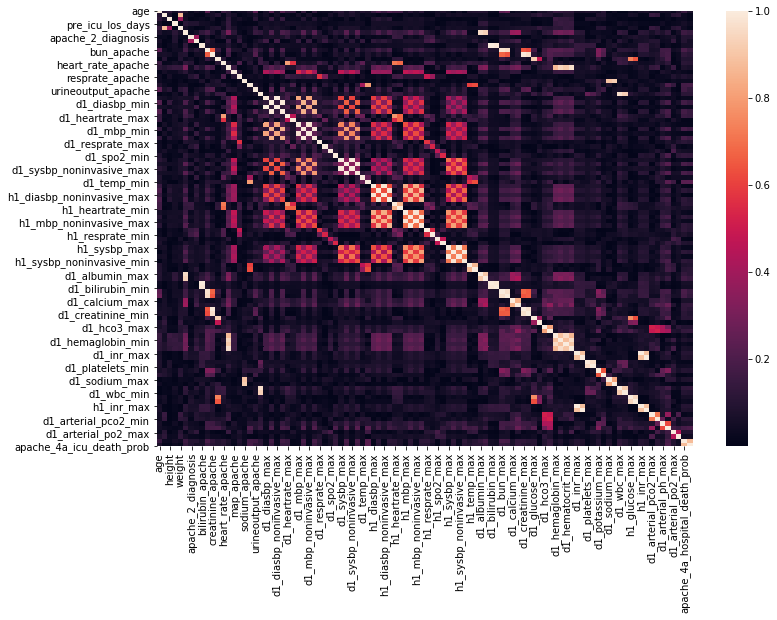

In [35]:
plt.figure(figsize =(12,8))
sns.heatmap(imputed_df.corr().abs())

In [36]:
imputed_df

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,68.000000,22.730000,180.3,0.541667,73.900000,2.300000,113.0,502.01,0.400000,31.000000,...,1.596476,1.482979,39.262738,35.520015,7.361388,7.315135,139.571329,108.360101,0.100000,0.050000
1,77.000000,27.420000,160.0,0.927778,70.200000,1.566189,108.0,203.01,0.311166,9.000000,...,1.300000,1.300000,37.000000,37.000000,7.450000,7.450000,51.000000,51.000000,0.470000,0.290000
2,25.000000,31.950000,172.7,0.000694,95.300000,2.924985,122.0,703.03,1.133633,25.765689,...,1.596476,1.482979,45.593601,39.479160,7.385911,7.329256,154.218337,115.374707,0.000000,0.000000
3,81.000000,22.640000,165.1,0.000694,61.700000,2.839223,203.0,1206.03,1.132054,26.201220,...,1.600000,1.100000,37.000000,27.000000,7.440000,7.340000,337.000000,102.000000,0.040000,0.030000
4,19.000000,22.735624,188.0,0.073611,85.146752,2.932082,119.0,601.01,1.134308,25.679708,...,1.596476,1.482979,44.698865,39.201902,7.394575,7.337947,173.289430,121.163504,0.049222,0.070294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.000000,23.060250,177.8,0.298611,72.900000,2.805806,113.0,501.06,1.183286,30.345618,...,1.100000,1.100000,48.000000,48.000000,7.340000,7.340000,144.000000,144.000000,0.120000,0.050000
91709,56.000000,47.179671,183.0,0.120139,158.000000,2.920253,113.0,501.05,1.112282,34.000000,...,1.596476,1.482979,85.000000,58.000000,7.260000,7.150000,187.000000,63.000000,0.030000,0.020000
91710,48.000000,27.236914,170.2,0.046528,78.900000,2.900000,123.0,702.01,1.145228,33.000000,...,1.596476,1.482979,20.000000,14.900000,7.360000,6.930000,136.000000,60.000000,0.050000,0.020000
91711,71.011615,23.297481,154.9,0.081944,55.900000,2.925753,108.0,203.01,1.105058,25.748169,...,1.596476,1.482979,39.000000,39.000000,7.370000,7.370000,55.000000,55.000000,0.070000,0.020000


In [37]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [38]:
reduced_dim_df = pd.concat([correlation(imputed_df.copy(), .9), categorical_df], axis = 1)
reduced_dim_df

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
0,68.000000,22.730000,180.3,0.541667,73.900000,2.300000,113.0,502.01,0.400000,31.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis
1,77.000000,27.420000,160.0,0.927778,70.200000,1.566189,108.0,203.01,0.311166,9.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory
2,25.000000,31.950000,172.7,0.000694,95.300000,2.924985,122.0,703.03,1.133633,25.765689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic
3,81.000000,22.640000,165.1,0.000694,61.700000,2.839223,203.0,1206.03,1.132054,26.201220,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular
4,19.000000,22.735624,188.0,0.073611,85.146752,2.932082,119.0,601.01,1.134308,25.679708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.000000,23.060250,177.8,0.298611,72.900000,2.805806,113.0,501.06,1.183286,30.345618,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis
91709,56.000000,47.179671,183.0,0.120139,158.000000,2.920253,113.0,501.05,1.112282,34.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis
91710,48.000000,27.236914,170.2,0.046528,78.900000,2.900000,123.0,702.01,1.145228,33.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic
91711,71.011615,23.297481,154.9,0.081944,55.900000,2.925753,108.0,203.01,1.105058,25.748169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory


## Categorical features

In [39]:
categorical_df.head(3)

,hospital_death,elective_surgery,ethnicity,gender,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,...,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
0,0,0,Caucasian,M,0,0.0,3.0,6.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis
1,0,0,Caucasian,F,0,0.0,1.0,3.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory
2,0,0,Caucasian,F,0,0.0,3.0,6.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic


In [40]:
categorical_df.nunique()

hospital_death                  2
elective_surgery                2
ethnicity                       6
gender                          2
apache_post_operative           2
arf_apache                      2
gcs_eyes_apache                 4
gcs_motor_apache                6
gcs_unable_apache               2
gcs_verbal_apache               5
intubated_apache                2
ventilated_apache               2
aids                            2
cirrhosis                       2
diabetes_mellitus               2
hepatic_failure                 2
immunosuppression               2
leukemia                        2
lymphoma                        2
solid_tumor_with_metastasis     2
apache_3j_bodysystem           11
dtype: int64

In [41]:
complet_df

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,GCS
0,68.000000,22.730000,180.3,0.541667,73.900000,2.300000,113.0,502.01,0.400000,31.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,13.0
1,77.000000,27.420000,160.0,0.927778,70.200000,1.566189,108.0,203.01,0.311166,9.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,5.0
2,25.000000,31.950000,172.7,0.000694,95.300000,2.924985,122.0,703.03,1.133633,25.765689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,14.0
3,81.000000,22.640000,165.1,0.000694,61.700000,2.839223,203.0,1206.03,1.132054,26.201220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,15.0
4,19.000000,22.735624,188.0,0.073611,85.146752,2.932082,119.0,601.01,1.134308,25.679708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.000000,23.060250,177.8,0.298611,72.900000,2.805806,113.0,501.06,1.183286,30.345618,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,15.0
91709,56.000000,47.179671,183.0,0.120139,158.000000,2.920253,113.0,501.05,1.112282,34.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,15.0
91710,48.000000,27.236914,170.2,0.046528,78.900000,2.900000,123.0,702.01,1.145228,33.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,13.0
91711,71.011615,23.297481,154.9,0.081944,55.900000,2.925753,108.0,203.01,1.105058,25.748169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,13.0


# Encoding

## Label encoding
Encode Male as 1 and female 0

In [42]:
complet_df['gender']= complet_df['gender'].apply(lambda x: 1 if x =='M' else 0)

## One hot encoding

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
encoding_df1 = complet_df[['ethnicity', 'apache_3j_bodysystem']]

In [45]:
encoding_df.columns.tolist()

['ethnicity', 'apache_3j_bodysystem']

empty_df = pd.DataFrame(index=categorical_df.index )
pd.concat([encoded_df,empty_df], axis =1)

In [47]:
features_need_encoding = ['ethnicity']

In [48]:
ohe = OneHotEncoder(sparse=False, categories='auto')
encoded_matrix = ohe.fit_transform(categorical_df[features_need_encoding])

In [49]:
ohe.categories_[0]

array(['African American', 'Asian', 'Caucasian', 'Hispanic',
       'Native American', 'Other/Unknown'], dtype=object)

In [50]:
encoded_df1 = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=categorical_df[features_need_encoding].index)
encoded_df1.head(3)

,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0


In [51]:
features_need_encoding = ['apache_3j_bodysystem']
ohe = OneHotEncoder(sparse=False, categories='auto')
encoded_matrix = ohe.fit_transform(categorical_df[features_need_encoding])
encoded_df2 = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=categorical_df[features_need_encoding].index)
encoded_df2.head(3)

,Cardiovascular,Gastrointestinal,Genitourinary,Gynecological,Hematological,Metabolic,Musculoskeletal/Skin,Neurological,Respiratory,Sepsis,Trauma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
pd.concat([encoded_df1,encoded_df2], axis =1)

,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,Cardiovascular,Gastrointestinal,Genitourinary,Gynecological,Hematological,Metabolic,Musculoskeletal/Skin,Neurological,Respiratory,Sepsis,Trauma
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
91709,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
91710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
91711,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [55]:
def one_hot_encoder(dataset):
    encoded_df = pd.DataFrame(index=dataset.index)
    features = dataset.columns.tolist()
    for i,feature in enumerate(features):
        ohe = OneHotEncoder(sparse=False, categories='auto')
        encoded_matrix = ohe.fit_transform(dataset[[feature]])
        encoded_dfi = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=dataset[feature].index)
        encoded_df = pd.concat([encoded_df,encoded_dfi], axis =1)
    return encoded_df


In [56]:
# One hot encode selected features
dataset = complet_df[['ethnicity', 'apache_3j_bodysystem']]
encoded_df = one_hot_encoder(dataset)
encoded_df

,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,Cardiovascular,Gastrointestinal,Genitourinary,Gynecological,Hematological,Metabolic,Musculoskeletal/Skin,Neurological,Respiratory,Sepsis,Trauma
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
91709,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
91710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
91711,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [57]:
# Concat encoded dataframe to the complete df
# Drop the selected features
complet_df = pd.concat([complet_df, encoded_df], axis=1).drop(columns =['ethnicity', 'apache_3j_bodysystem'])

# Modeling

## Baseline

In [58]:
(complet_df.shape[0]-(complet_df['hospital_death']).sum())/complet_df.shape[0]

0.9136981671082617

## Logist regression

### Building a Model

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
y = complet_df['hospital_death']
X = complet_df.drop(columns='hospital_death')

In [61]:
logit = LogisticRegression()
logit.fit(X, y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
logit.score(X, y)

0.9251142149967835

### AUC Roc score

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [64]:
# # generate 2 class dataset
# X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# # split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
#ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')
# model.fit(trainX, trainy)
# predict probabilities
lr_probs = logit.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs 

array([0.08753306, 0.43640171, 0.0043883 , ..., 0.02168552, 0.03642812,
       0.0706694 ])

Logistic: ROC AUC=0.877


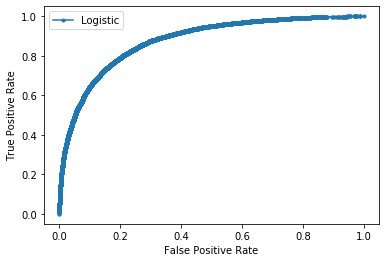

In [65]:
# calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Decision Tree

### Building a model

In [66]:
from sklearn.tree import DecisionTreeClassifier


In [67]:
dt = DecisionTreeClassifier(max_depth=10, random_state=123)
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [68]:
dt.score(X, y)

0.9413060307699017

### Auc Roc score

In [69]:
lr_probs = dt.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs 

array([0.05776946, 0.28571429, 0.00397959, ..., 0.0474359 , 0.1119403 ,
       0.08737108])

Logistic: ROC AUC=0.892


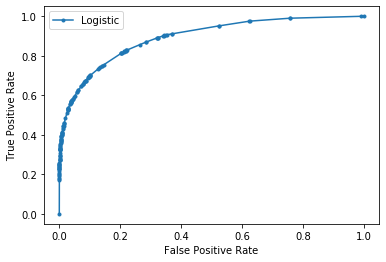

In [70]:
# calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#  Some_thing to do later

In [71]:
object_df = reduced_dim_df.select_dtypes('object')
object_df.nunique()

ethnicity                6
gender                   2
apache_3j_bodysystem    11
dtype: int64

Systems that estimate the risk of hospital death based on severity of disease scoring have become increasingly popular in the last 20 years, particularly in the field of critical care medicine. The first 2 to be introduced were the Acute Physiology and Chronic Health Evaluation (APACHE) System in 1981 and the Simplified Acute Physiology Score (SAPS) in 1988. Further research resulted in "improved" editions, APACHE II[1] in 1985, and SAPS II[2] in 1993. A later version, APACHE III,[3] is now coming into general use.
Briefly, the APACHE III is used to produce an equation predicting hospital mortality after the first day of ICU treatment. There are 4 components: age, major disease category (reason for ICU admission), acute (current) physiology, and prior site of healthcare (eg, hospital floor, emergency room, etc.)

So **just use apache_3j_bodysystem**

(object_df['apache_3j_bodysystem'] != object_df['apache_2_bodysystem']).sum()

In [ ]:
object_df['icu_type'].unique()